In [1]:
from IPython.display import clear_output

In [2]:
%pip install gymnasium
%pip install flappy_bird_gymnasium

clear_output()

In [2]:
# %pip install torch matplotlib

clear_output()

# Content

In this demo, we will build a custom PPO model implementation using pytorch and then train that implementation on flappy bird game.

for the environment, we will use flappy_bird_gymnasium environment. You can read more about this environment [here](https://github.com/markub3327/flappy-bird-gymnasium)

## PPO

PPO is motivated by the same question as TRPO: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? Where TRPO tries to solve this problem with a complex second-order method, PPO is a family of first-order methods that use a few other tricks to keep new policies close to old. PPO methods are significantly simpler to implement, and empirically seem to perform at least as well as TRPO.

There are two primary variants of PPO: PPO-Penalty and PPO-Clip.

**PPO-Penalty** approximately solves a KL-constrained update like TRPO, but penalizes the KL-divergence in the objective function instead of making it a hard constraint, and automatically adjusts the penalty coefficient over the course of training so that it's scaled appropriately.

**PPO-Clip** doesn't have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

Read more [here](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

Here, we'll focus only on PPO-Clip.

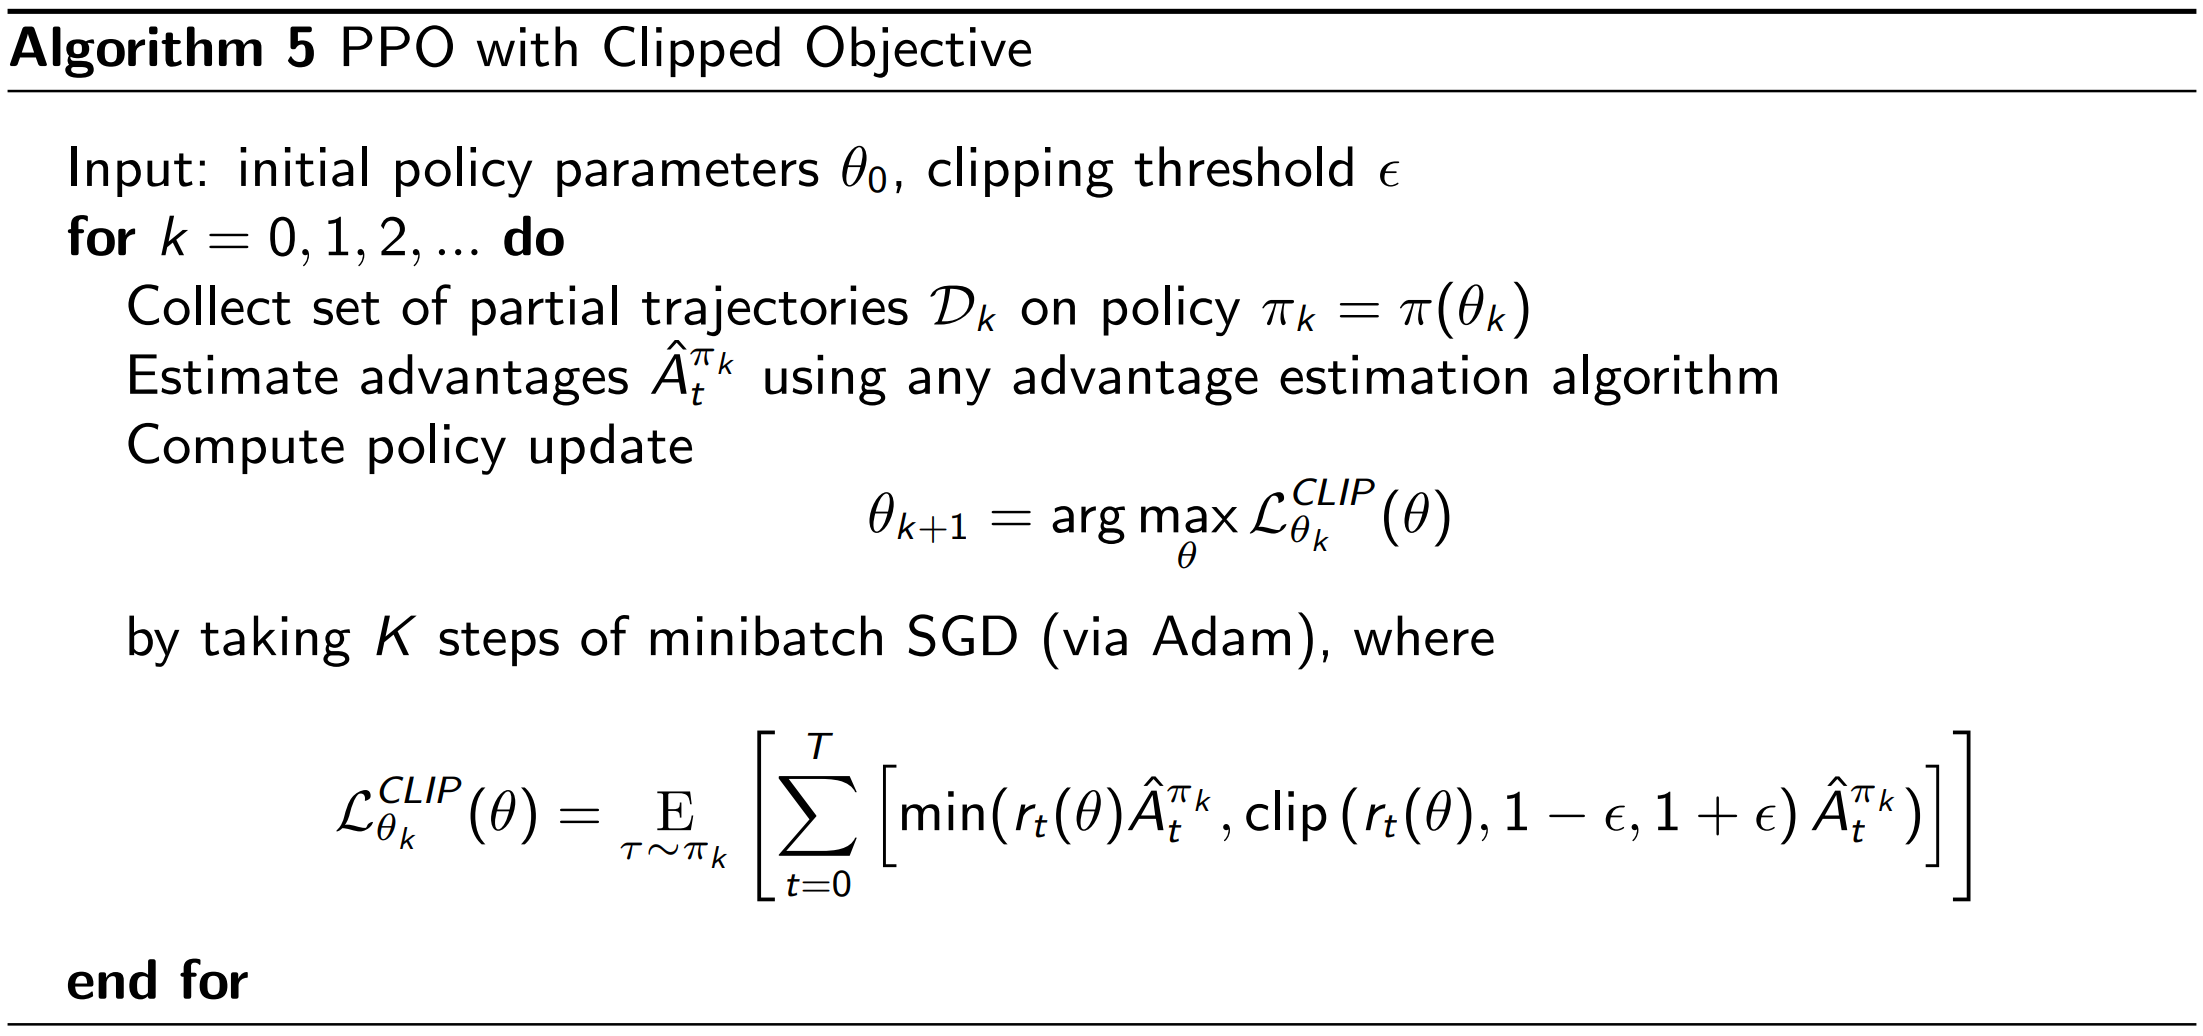

[Image Source](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/)

In [3]:
import gymnasium as gym

import flappy_bird_gymnasium

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

## Let's define our model

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 32)
        self.actor = nn.Linear(32, output_dim)
        self.critic = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.actor(x), self.critic(x)

# Proximal Policy Optimization Agent
class PPOAgent:
    def __init__(self, input_dim, output_dim, lr=0.001, gamma=0.99, epsilon=0.2, device='cpu'):
        self.actor_critic = ActorCritic(input_dim, output_dim).to(device)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = device

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        logits, _ = self.actor_critic(state)
        action_probs = F.softmax(logits, dim=-1)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        return action.item()

    def compute_returns(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        return returns

    def update(self, states, actions, returns, advantages):
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int32).to(self.device)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)

        logits, values = self.actor_critic(states)
        action_probs = F.softmax(logits, dim=-1)
        action_dist = torch.distributions.Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)

        ratio = torch.exp(log_probs - log_probs.detach())
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        critic_loss = F.smooth_l1_loss(values.squeeze(), returns)

        total_loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()


## Initialize the environment and model

In [7]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)

In [9]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
num_episodes = 10000
max_steps = 1000

lr = 1e-3
gamma = 0.90
epsilon = 0.2

In [10]:
agent = PPOAgent(input_dim, output_dim, lr, gamma, epsilon, device=device)

## Training the model

In [ ]:
for episode in range(num_episodes):

    state = env.reset()[0]
    done = False
    episode_rewards = []
    episode_states = []
    episode_actions = []

    for step in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)

        state = next_state

        if done or truncated:
            break

    returns = agent.compute_returns(episode_rewards)

    # Compute advantages
    values = agent.actor_critic(torch.tensor(episode_states, dtype=torch.float32).to(device))[1].squeeze().detach()
    advantages = returns - values

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Update policy
    agent.update(episode_states, episode_actions, returns, advantages)

    total_reward = sum(episode_rewards)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()

## Visualizing model's performance

In [15]:
state = env.reset()[0]
frames = []

while True:
    with torch.no_grad():
        action = agent.select_action(state)
        state_next, r, done, truncated, info = env.step(action)
        frames.append(env.render())
        state = state_next
        if done or truncated:
            break

In [16]:
frames_to_video(frames, fps=24)